In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [4]:
# Relationship for "special" FFT
# For both the individual tiles *and* the whole thing, it is true that
# the second half is just the reversed conjugate of the first half.
# In retrospect that shouldn't be a surprise!
a = np.array([1, 0, 0, 0, 3.4, 0, 0, 0, 2.19, 0, 0, 0, 0.765, 0, 0, 0])
print(np.fft.rfft(a))

[ 7.355+0.j    -1.19 -2.635j -0.975-0.j    -1.19 +2.635j  7.355+0.j
 -1.19 -2.635j -0.975+0.j    -1.19 +2.635j  7.355+0.j   ]


In [23]:
# Check that my code works (for a 2d array)
from numpy.fft import fft, fftn, rfft, rfftn, irfftn
Nnum = 4
a = np.random.random((8*Nnum,8*Nnum))
subset = np.zeros(a.shape)
subset[::Nnum, ::Nnum] = a[::Nnum, ::Nnum]
longhandResult = fftn(subset)

reduced = a[::Nnum, ::Nnum]
reducedShape = reduced.shape
fshape = a.shape
reducedF = fftn(reduced, reducedShape)
result = np.tile(reducedF, (1,Nnum))   # edited
#result *= np.exp(-1j * aa * 2*np.pi / fshape[1] * np.arange(result.shape[1]))
result = np.tile(result, (Nnum,1))
#result *= np.exp(-1j * bb * 2*np.pi / fshape[0] * np.arange(result.shape[0]))[:,np.newaxis]

print(np.max(np.abs(result - longhandResult)))


0.0


In [11]:
a = np.pad(np.random.random(16), (0,0), 'constant')
print(a)
print(a[::-1])

[0.8863861  0.94376279 0.22873319 0.68661514 0.24783578 0.17129133
 0.69678102 0.3534258  0.46877118 0.76330932 0.75897284 0.95378466
 0.51964095 0.42295071 0.88461372 0.13277243]
[0.13277243 0.88461372 0.42295071 0.51964095 0.95378466 0.75897284
 0.76330932 0.46877118 0.3534258  0.69678102 0.17129133 0.24783578
 0.68661514 0.22873319 0.94376279 0.8863861 ]


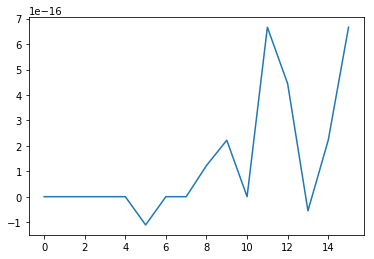

In [21]:
# Relationship between the FT of a and of the reversed version of a
af = np.fft.fft(a)
afm = np.fft.fft(a[::-1])
afm = afm.conj() * np.exp(1j * 2*np.pi / a.shape[0] * np.arange(a.shape[0]))
plt.plot((np.angle(af) - np.angle(afm)))

(-7, 7)

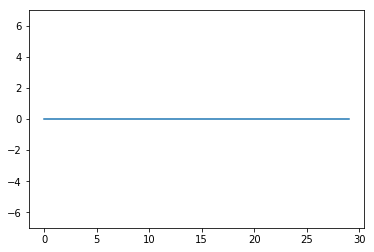

In [30]:
# Relationship between the FT of a and of the reversed version of a when you take into account padding
padLength = 14
af = np.fft.fft(np.pad(a, (0,padLength), 'constant'))
afm = np.fft.fft(np.pad(a[::-1], (0,padLength), 'constant'))
afm = afm.conj() * np.exp(1j * 2*np.pi / af.shape[0] * np.arange(af.shape[0]))
afm *= np.exp(1j * padLength * 2*np.pi / af.shape[0] * np.arange(af.shape[0]))
plt.plot((np.angle(af) - np.angle(afm)))
plt.ylim(-7,7)

In [35]:
# Relationship between the FT of a and the transposed version of a when you take into account padding
b = np.random.random((16,16))
bf = np.fft.fft2(np.pad(b, ((0,padLength),(0,padLength)), 'constant'))
bft = np.fft.fft2(np.pad(b.transpose(), ((0,padLength),(0,padLength)), 'constant'))
print(np.max(np.abs(bf - bft.transpose())))

1.432144669219779e-14


In [60]:
# Work out some code that covers the whole subaperture using mirror/transpose operations
# to minimize the number of times we actually need to compute the FFT of the PSF matrix.

Nnum = 7

covered = np.zeros((Nnum,Nnum))

def process(aa,bb):
    print(aa,bb)
    covered[aa,bb] += 1
    
def processFor2(aa,bb,Nnum,mirrorX):
    print('processFor2', aa,bb,mirrorX)
    process(aa,bb)
    if mirrorX:
        process(aa,Nnum-bb-1)

def processFor(aa,bb,Nnum,mirrorX,mirrorY):
    processFor2(aa,bb,Nnum,mirrorX)
    if mirrorY:
        processFor2(Nnum-aa-1,bb,Nnum,mirrorX)
        
    
for aa in tqdm.tqdm(range(int((Nnum+1)/2)), leave=False, desc='y'):
    for bb in tqdm.tqdm(range(aa,int((Nnum+1)/2)), leave=False, desc='x'):    
        cent = int(Nnum/2)
        transpose = ((aa != bb) and (aa != (Nnum-bb-1)))
        mirrorX = (bb != cent)
        mirrorY = (aa != cent)
        processFor(aa,bb,Nnum,mirrorX,mirrorY)
        if transpose:
            processFor(bb,aa,Nnum,mirrorY,mirrorX) # Note that mx,my are swapped after transpose

print(covered)

x:   0%|          | 0/4 [00:00<?, ?it/s]
                                        
x:   0%|          | 0/3 [00:00<?, ?it/s]
                                        
x:   0%|          | 0/2 [00:00<?, ?it/s]
                                        
x:   0%|          | 0/1 [00:00<?, ?it/s]
                                        

('processFor2', 0, 0, True)
(0, 0)
(0, 6)
('processFor2', 6, 0, True)
(6, 0)
(6, 6)
('processFor2', 0, 1, True)
(0, 1)
(0, 5)
('processFor2', 6, 1, True)
(6, 1)
(6, 5)
('processFor2', 1, 0, True)
(1, 0)
(1, 6)
('processFor2', 5, 0, True)
(5, 0)
(5, 6)
('processFor2', 0, 2, True)
(0, 2)
(0, 4)
('processFor2', 6, 2, True)
(6, 2)
(6, 4)
('processFor2', 2, 0, True)
(2, 0)
(2, 6)
('processFor2', 4, 0, True)
(4, 0)
(4, 6)
('processFor2', 0, 3, False)
(0, 3)
('processFor2', 6, 3, False)
(6, 3)
('processFor2', 3, 0, True)
(3, 0)
(3, 6)
('processFor2', 1, 1, True)
(1, 1)
(1, 5)
('processFor2', 5, 1, True)
(5, 1)
(5, 5)
('processFor2', 1, 2, True)
(1, 2)
(1, 4)
('processFor2', 5, 2, True)
(5, 2)
(5, 4)
('processFor2', 2, 1, True)
(2, 1)
(2, 5)
('processFor2', 4, 1, True)
(4, 1)
(4, 5)
('processFor2', 1, 3, False)
(1, 3)
('processFor2', 5, 3, False)
(5, 3)
('processFor2', 3, 1, True)
(3, 1)
(3, 5)
('processFor2', 2, 2, True)
(2, 2)
(2, 4)
('processFor2', 4, 2, True)
(4, 2)
(4, 4)
('processFor2', 